In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

path = 'services/backend/data/shoe_pngs'
files = os.listdir(os.path.join(os.getcwd(),path))
file_paths = [os.path.join(os.getcwd(),path,file) for file in files]
imgs = [Image.open(file_path) for file_path in file_paths]

In [2]:
def crop_whitespace(image):
    img = np.array(image)

    def find_first_non_white_row(image_array,threshold):
        for row in range(image_array.shape[0]):
            if (np.sum(image_array[row] > 253)/(3*image_array.shape[1]) < threshold):
                return row
        return None

    def find_first_non_white_column(image_array,threshold):
        for col in range(image_array.shape[1]):
            if (np.sum(image_array[:,col] > 253)/(3*image_array.shape[0]) < threshold):
                return col
        return None


    top_row = find_first_non_white_row(img,1)
    bottom_row = find_first_non_white_row(np.flipud(img),0.95)

    left_col = find_first_non_white_column(img,0.97)
    right_col = find_first_non_white_column(np.fliplr(img),0.97)
    left,upper,right,lower = left_col,top_row,img.shape[1]-right_col,img.shape[0] - bottom_row
    cropped_img = img[upper:lower,left:right]
    
    return cropped_img

cropped_imgs = [crop_whitespace(img) for img in imgs]


In [3]:
def add_whitespace_with_ar(img_array,target_ar):

    #current_aspect_ratio = img.shape[1]/img.shape[0]
    desired_height = int(img_array.shape[1]*target_ar)
    rows_to_add = desired_height - img_array.shape[0]

    if rows_to_add > 0:
        white_row = np.full((1,img_array.shape[1],3),255,dtype=np.uint8)
        padded_img_array = np.vstack((white_row,) * rows_to_add + (img_array,))
        return padded_img_array
    else:
        return img_array

def resize_image(img_array,new_size=(288,224)):
    img = Image.fromarray(img_array)
    resized_img = img.resize(new_size)
    return resized_img

max_aspect_ratio = max(shape[0]/shape[1] for shape in [cropped_img.shape for cropped_img in cropped_imgs])
padded_images = [add_whitespace_with_ar(cropped_img,max_aspect_ratio) for cropped_img in cropped_imgs]
final_images = [resize_image(padded_image) for padded_image in padded_images]


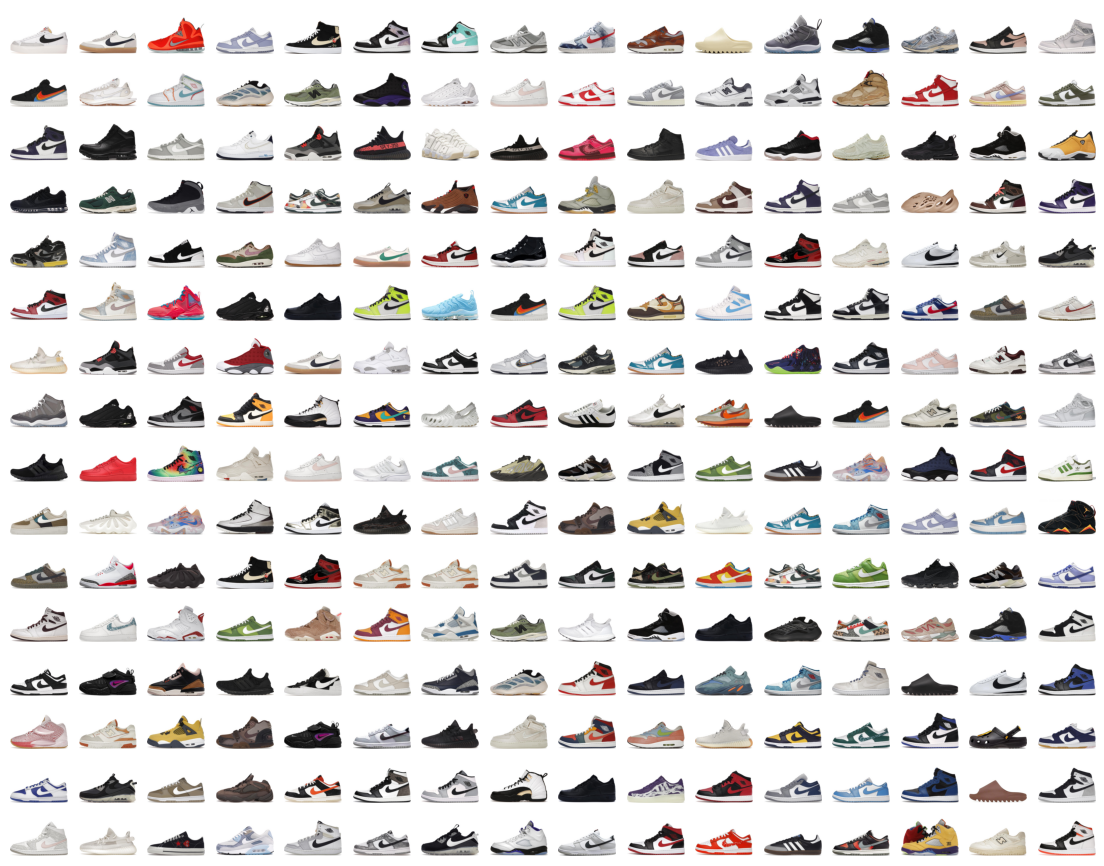

In [4]:
import random
n_rows = 16
n_cols = 16
fig,axs = plt.subplots(n_rows,n_cols,figsize=(14,11))

for i in range(n_rows):
    for j in range(n_cols):
        axs[i,j].imshow(np.array(final_images[random.randrange(len(final_images))]))
        axs[i,j].set_axis_off()

In [5]:
#GET TOKENS FOR FINETUNING
import pandas as pd

metadata_df = pd.read_csv(os.path.join(os.getcwd(),'data/clean_shoe_metadata.csv'))
tokens_df = pd.read_csv(os.path.join(os.getcwd(),'data/shoe_tokens.csv'))

id                                                    289
title                   Jordan 1 Low Black Grey Pink (GS)
colorway                                  Black/Grey/Pink
releaseDate                                    2022-05-02
retailPrice                                          90.0
brand                                              Jordan
model                                        Jordan 1 Low
lowestAsk                                             114
numberOfAsks                                          143
highestBid                                             89
numberOfBids                                           91
annualHigh                                            218
annualLow                                              45
volatility                                       0.063166
pricePremium                                        0.311
lastSale                                              100
changeValue                                             0
changePercenta

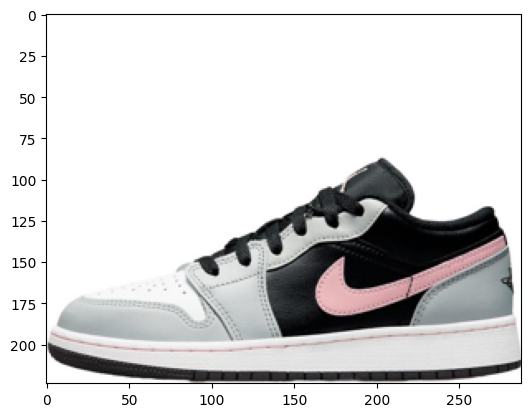

In [6]:
png_path_to_id_mapping = dict(zip(metadata_df['id'],metadata_df['png_path']))

id_to_image_mapping = {}
for id in png_path_to_id_mapping.keys():
    id_to_image_mapping[id] = files.index(png_path_to_id_mapping [id])

test_id = 289
print(metadata_df.loc[metadata_df['id']==test_id].iloc[0])
plt.imshow(np.array(final_images[id_to_image_mapping[test_id]]))

In [7]:
import datetime

prod_ages = (pd.to_datetime(datetime.date(2023,9,13)) - pd.to_datetime(metadata_df['releaseDate'])).dt.days
prod_ages = prod_ages/max(prod_ages)
metadata_df['prod_age'] = prod_ages

metadata_df['prod_sales'] = metadata_df['salesLast72Hours']/max(metadata_df['salesLast72Hours'])
metadata_df['prod_premium'] = (metadata_df['pricePremium'] - min(metadata_df['pricePremium']))/max(metadata_df['pricePremium'] - min(metadata_df['pricePremium']))
metadata_df['prod_high'] = metadata_df['annualHigh']/max(metadata_df['annualHigh'])
metadata_df['prod_low'] = metadata_df['annualLow']/max(metadata_df['annualLow'])

In [8]:
unique_tags = tokens_df['model'].unique()

tag_vectors = {}
for prod_id, group in tokens_df.groupby('prod_id'):
    prod_tag_list = list(group['model'])
    binary_vector = [1 if tag in prod_tag_list else 0 for tag in unique_tags]
    tag_vectors[prod_id] = binary_vector
metadata_df['prod_title_tags'] = metadata_df['id'].map(tag_vectors)

import re
colour_tags = [list(set(x.lower() for x in re.split('/|-| ',cw))) for cw in metadata_df['colorway']]
unique_colour_tags = np.unique([colour for colours in colour_tags for colour in colours])
colour_vectors = [[1 if tag in colour_tag else 0 for tag in unique_colour_tags] for colour_tag in colour_tags]
metadata_df['prod_colour_tags'] = colour_vectors

In [9]:
feature_df = metadata_df[['id','title','colorway','prod_age','prod_sales','prod_premium','prod_high','prod_low','prod_title_tags','prod_colour_tags']]

numerical_columns = ['prod_age','prod_sales','prod_premium','prod_high','prod_low']
tag_columns = ['prod_title_tags','prod_colour_tags']

numerical_vector = feature_df[numerical_columns].to_numpy()
title_tags_vector = feature_df['prod_title_tags']
colour_tags_vector = feature_df['prod_colour_tags']

labels = []
for i in range(len(numerical_vector)):
    labels.append(np.concatenate([numerical_vector[i],title_tags_vector[i],colour_tags_vector[i]]))
labels = np.array(labels)

prod_ids = list(feature_df['id'])
input_images = np.array([np.array(final_images[id_to_image_mapping[prod_id]] )for prod_id in prod_ids])

product_info = feature_df[['id','title','colorway']]

print(input_images.shape)
print(labels.shape)

(934, 224, 288, 3)
(934, 694)


In [10]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Preprocess your data (assuming you want to use ResNetV2 preprocessing)
images = tf.keras.applications.mobilenet_v2.preprocess_input(input_images)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the pre-trained ResNet50V2 model with weights from ImageNet
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 288, 3))

# Remove the top layers (including the classifier)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
x = Dense(1024, activation='relu')(x)  # Add your custom layers here
output = Dense(694, activation='sigmoid')(x)  # Output layer with sigmoid activation for multilabel classification

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model on your data
batch_size = 4
epochs = 1
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=2 # Include the TensorBoard callback
)

# Save the model for future use
#model.save("fine_tuned_resnet50v2.h5")


2023-09-14 04:50:06.861703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 04:50:15.664679: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 04:50:24.256893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


9406464/9406464 [==============================] - 0s 0us/step


: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs
